# Starting Off
Slack me the answer to the following question:

Sometimes when trying to classify problems like fraud detection, the dataset will have a lot of non-fraud cases and realtively few fraud cases.  How could a class imbalance cause a problem with your model. 

*Hint: use the term bias in your answer*

# Classification Practicum with Class Imbalance

Agenda:
- Review class imbalance
- Review code for different ways to handle class imbalance
- Review code for Random Forest with gridsearch
- Practice both class imbalance and Random Forest on credit data.

In [2]:
import pandas as pd
import numpy as np
from sklearn import metrics

In [89]:
# Read in data and split data to be used in the models
titanic = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/nyc-mhtn-ds-042219-lectures/master/Module_4/cleaned_titanic.csv', index_col='PassengerId')



In [90]:
# Create matrix of features
X = titanic.drop('Survived', axis = 1) # grabs everything else but 'Survived'

# Create target variable
y = titanic['Survived'] # y is the column we're trying to predict

# Create a list of the features being used in the 
feature_cols = X.columns

# Handling Class Imbalance

## Visualizing Class Imbalance

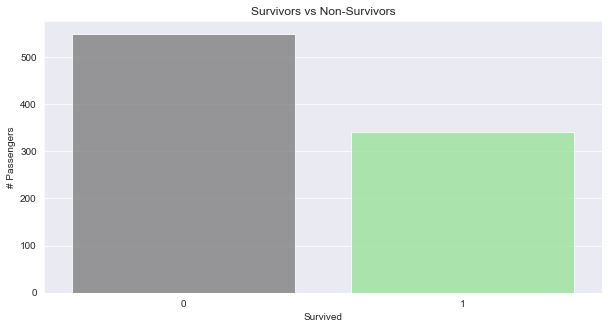

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(y, alpha =.80, palette= ['grey','lightgreen'])
plt.title('Survivors vs Non-Survivors')
plt.ylabel('# Passengers')
plt.show()

## Run a Dummy Classifier for Baseline Assessment

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)

# DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)




**Questions:**

- What do you think the accuracy score will be for this model?
- What do you think the F-1 Score will be for this model?

In [7]:

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, dummy_pred))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, dummy_pred))

Test Accuracy score:  0.6547085201793722
Test F1 score:  0.0


/Users/erikadauria/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## Run a classification Model with class imbalance

Below you will see there is code for fitting a logistic regression model to the data. 

In [8]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver='liblinear')

lr_clf.fit(X_train, y_train)

y_pred_test = lr_clf.predict(X_test)



# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_test))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, y_pred_test))

Test Accuracy score:  0.7847533632286996
Test F1 score:  0.6619718309859155


## Prepping data for handling class imbalances

We are goign to change the training dataset to which we fit our model, so we want to bring our training data back together before we make those changes. 

In [9]:
# concatenate our training data back together
training  = pd.concat([X_train, y_train], axis=1)

In [10]:
# separate minority and majority classes
deceased = training[training.Survived==0]
survived = training[training.Survived==1]

In [11]:
# Get a class count to understand the class imbalance.
print('deceased count: '+ str(len(deceased)))
print('survived count: '+ str(len(survived)))

deceased count: 403
survived count: 263


In [12]:
from sklearn.utils import resample


![alt text](images/resampling.png)

## Upsampling

In [13]:
# upsample minority
survived_upsampled = resample(survived,
                          replace=True, # sample with replacement
                          n_samples=len(deceased), # match number in majority class
                          random_state=23) # reproducible results

In [16]:
# combine majority and upsampled minority
upsampled = pd.concat([deceased, survived_upsampled])

# check new class counts
upsampled.Survived.value_counts()

1    403
0    403
Name: Survived, dtype: int64

Now that we have balanced classes, lets see how this can affect the performance of the model.  

In [17]:
# trying logistic regression again with the balanced dataset
y_train = upsampled.Survived
X_train = upsampled.drop('Survived', axis=1)


# upsampled_dt = DecisionTreeClassifier(max_depth=5)
upsampled_lr = LogisticRegression(solver='liblinear')


# upsampled_dt.fit(X_train, y_train)
upsampled_lr.fit(X_train, y_train)


# upsampled_pred = upsampled_dt.predict(X_test)
upsampled_pred = upsampled_lr.predict(X_test)



# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, upsampled_pred))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, upsampled_pred))



Test Accuracy score:  0.7713004484304933
Test F1 score:  0.6577181208053691


## Downsampling

In [18]:
# downsample majority
survived_downsampled = resample(deceased,
                                replace = False, # sample without replacement
                                n_samples = len(survived), # match minority n
                                random_state = 23) # reproducible results




In [19]:
# combine minority and downsampled majority
downsampled = pd.concat([survived_downsampled, survived])

# checking counts
downsampled.Survived.value_counts()

1    263
0    263
Name: Survived, dtype: int64

In [20]:
# trying logistic regression again with the balanced dataset
y_train = downsampled.Survived
X_train = downsampled.drop('Survived', axis=1)


# downsampled_dt = DecisionTreeClassifier(max_depth=5)
downsampled_lr = LogisticRegression(solver='liblinear')


# downsampled_dt.fit(X_train, y_train)
downsampled_lr.fit(X_train, y_train)


# downsampled_pred = upsampled_dt.predict(X_test)
downsampled_pred = downsampled_lr.predict(X_test)



# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, downsampled_pred))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, downsampled_pred))

Test Accuracy score:  0.7802690582959642
Test F1 score:  0.6711409395973155


## Over-sampling: SMOTE

SMOTE (Synthetic Minority Oversampling Technique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

![alt text](images/smote.png)

In [22]:
!pip install imblearn

  Using cached https://files.pythonhosted.org/packages/e5/4c/7557e1c2e791bd43878f8c82065bddc5798252084f26ef44527c02262af1/imbalanced_learn-0.4.3-py3-none-any.whl


In [23]:
from imblearn.over_sampling import SMOTE

In [24]:

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)

sm = SMOTE(random_state=23, ratio=1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [25]:
# smote_dt = DecisionTreeClassifier(max_depth=5)
smote_lr = LogisticRegression(solver='liblinear')


# smote_dt.fit(X_train, y_train)
smote_lr.fit(X_train, y_train)


# smote_pred = smote_dt.predict(X_test)
smote_pred = smote_lr.predict(X_test)



# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, smote_pred))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, smote_pred))

Test Accuracy score:  0.7847533632286996
Test F1 score:  0.68


## Under-sampling: Tomek links

Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.

![alt text](images/tomek.png)

In [26]:
from collections import Counter
from imblearn.under_sampling import TomekLinks # doctest: +NORMALIZE_WHITESPACE



In [27]:
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))


Resampled dataset shape Counter({0: 403, 1: 369})


In [28]:
feature_cols

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'youngin', 'male', 'Q', 'S'], dtype='object')

In [30]:
# remove Tomek links
tl = TomekLinks(return_indices=True)
X_resampled, y_resampled, idx_resampled = tl.fit_sample(X_train, y_train)

In [34]:
len(X_resampled)

772

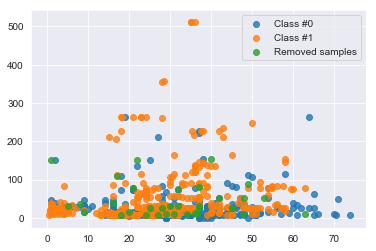

In [35]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

idx_samples_removed = np.setdiff1d(np.arange(X_train.shape[0]),
                                   idx_resampled)
idx_class_0 = y_resampled == 0
plt.scatter(X_resampled[idx_class_0, 1], X_resampled[idx_class_0, 4],
            alpha=.8, label='Class #0')
plt.scatter(X_resampled[~idx_class_0, 1], X_resampled[~idx_class_0, 4],
            alpha=.8, label='Class #1')
plt.scatter(X_train[idx_samples_removed, 1], X_train[idx_samples_removed, 4],
             alpha=.8, label='Removed samples')
plt.legend()

In [36]:
len(idx_samples_removed)

34

In [37]:
len(X_train)

806

In [38]:
len(X_resampled)

772

In [39]:
tomek_lr = LogisticRegression()


tomek_lr.fit(X_resampled, y_resampled)


tomek_pred = tomek_lr.predict(X_test)



# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, tomek_pred))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, tomek_pred))

Test Accuracy score:  0.7757847533632287
Test F1 score:  0.6621621621621622


/Users/erikadauria/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# Applying this to the Major lab

In [74]:
df = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/nyc-mhtn-ds-042219-lectures/master/Module_4/classification_evaluation_mini_project/classification_lab_data.csv')
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,50000,1,2,2,49,0,0,0,0,0,...,93880,99418,101392,2852,2784,2603,10000,3164,2868,1
1,30000,1,2,1,39,0,0,0,0,0,...,16469,14670,11214,2007,2000,2000,417,1500,1500,0
2,260000,1,1,2,27,0,0,0,0,0,...,76699,56738,39134,30000,4132,3410,2600,1800,1200,0
3,200000,2,2,1,33,0,0,0,0,0,...,25237,22131,13774,4000,2000,600,3000,4000,100,0
4,50000,1,1,2,27,0,0,0,0,0,...,17653,17697,18068,1558,1278,1589,633,656,783,0


In [75]:
# Create matrix of features
X = df.drop('default payment next month', axis = 1) # grabs everything else but 'Survived'

# Create target variable
y = df['default payment next month'] # y is the column we're trying to predict

# Create a list of the features being used in the 
feature_cols = X.columns

In [76]:
feature_cols

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')

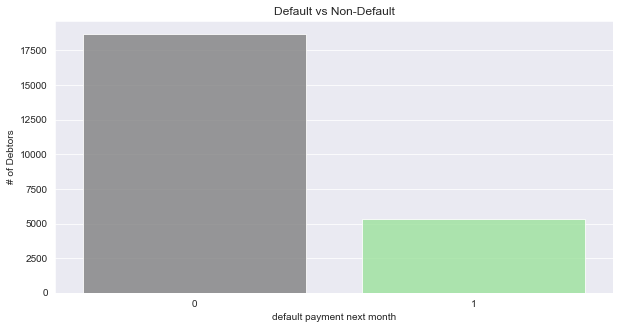

In [77]:
plt.figure(figsize = (10,5))
sns.countplot(y, alpha =.80, palette= ['grey','lightgreen'])
plt.title('Default vs Non-Default')
plt.ylabel('# of Debtors')
plt.show()

In [78]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)

# DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)


In [79]:

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, dummy_pred))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, dummy_pred))

Test Accuracy score:  0.779
Test F1 score:  0.0


/Users/erikadauria/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [80]:
pd.DataFrame([y_test, y_pred_test]).T

,default payment next month,Unnamed 0
401,1.0,NaN
4432,0.0,NaN
876,0.0,NaN
4422,0.0,NaN
18367,1.0,NaN
13767,0.0,NaN
3732,0.0,NaN
22429,0.0,NaN
12155,0.0,NaN
3655,0.0,NaN


In [81]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

/Users/erikadauria/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/erikadauria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  import sys
/Users/erikadauria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [82]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train)

y_pred_class = knn.predict(X_test)

In [83]:
print('Accuracy:' + str(metrics.accuracy_score(y_test, y_pred_class)))
print('F1: ' + str(metrics.f1_score(y_test, y_pred_class)))

Accuracy:0.7918333333333333
F1: 0.42468908337171807


In [84]:
#create a container to track the scores
k_scores=[]

#set up a loop to fit the model using a different values of K

k_range = list(range(9, 22,2))
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_class= knn.predict(X_test)
    k_scores.append(metrics.f1_score(y_pred_class, y_test))
    
    #fit the model and get the score on a evaluation metric

# Print out the scores to see which one is best. 

print(k_scores)

[0.4482090997095838, 0.44282238442822386, 0.4510763209393346, 0.4434567901234568, 0.44400199104031857, 0.44642857142857145, 0.4480712166172107]


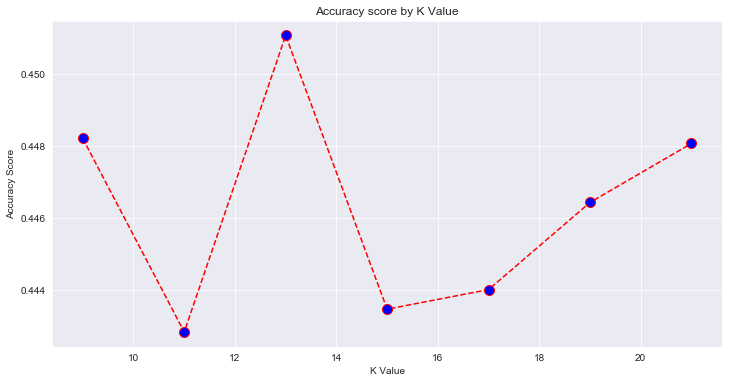

In [85]:
import matplotlib.pyplot as plt  

plt.figure(figsize=(12, 6))  
plt.plot(k_range, k_scores, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Accuracy score by K Value')  
plt.xlabel('K Value')  
plt.ylabel('Accuracy Score') 
plt.show()

## Upsampling

In [86]:
# upsample minority
survived_upsampled = resample(survived,
                          replace=True, # sample with replacement
                          n_samples=len(deceased), # match number in majority class
                          random_state=23) # reproducible results

In [87]:
# combine majority and upsampled minority
upsampled = pd.concat([deceased, survived_upsampled])

# check new class counts
upsampled.Survived.value_counts()

1    403
0    403
Name: Survived, dtype: int64

In [88]:
# trying logistic regression again with the balanced dataset
y_train = upsampled.Survived
X_train = upsampled.drop('Survived', axis=1)


# upsampled_dt = DecisionTreeClassifier(max_depth=5)
upsampled_lr = LogisticRegression(solver='liblinear')


# upsampled_dt.fit(X_train, y_train)
upsampled_lr.fit(X_train, y_train)


# upsampled_pred = upsampled_dt.predict(X_test)
upsampled_pred = upsampled_lr.predict(X_test)



# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, upsampled_pred))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, upsampled_pred))

ValueError: X has 23 features per sample; expecting 9

## Over-sampling: Smote

In [69]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)

sm = SMOTE(random_state=23, ratio=1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [70]:
# smote_dt = DecisionTreeClassifier(max_depth=5)
smote_lr = LogisticRegression(solver='liblinear')


# smote_dt.fit(X_train, y_train)
smote_lr.fit(X_train, y_train)


# smote_pred = smote_dt.predict(X_test)
smote_pred = smote_lr.predict(X_test)



# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, smote_pred))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, smote_pred))

Test Accuracy score:  0.5711666666666667
Test F1 score:  0.43537414965986404


## Down sampling

In [63]:
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 14017, 1: 13623})


In [65]:
tl

TomekLinks(n_jobs=1, random_state=None, ratio=None, return_indices=False,
      sampling_strategy='auto')

In [60]:
# remove Tomek links
tl = TomekLinks(return_indices=True)
X_resampled, y_resampled, idx_resampled = tl.fit_sample(X_train, y_train)

In [61]:
tomek_lr = LogisticRegression()


tomek_lr.fit(X_resampled, y_resampled)


tomek_pred = tomek_lr.predict(X_test)



# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, tomek_pred))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, tomek_pred))

/Users/erikadauria/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Test Accuracy score:  0.5806666666666667
Test F1 score:  0.43814202769093347
